In [1]:
import numpy as np
import muram as muram
import matplotlib.pyplot as plt
from glob import glob

In [2]:
path = 'data'
intensity_files = sorted(glob(f'{path}/I_out*'))
iterations = [int(file[-6:]) for file in intensity_files]

In [3]:
Intensities = []
velocities = []
times = []
for iter in iterations:
    # load the intensity data
    Intensities.append(muram.MuramIntensity(path, iter))
    # load the velocity data
    tau_slice = muram.MuramTauSlice(path, iter, 1)
    # extract the velocity data
    vx, vy = tau_slice.vy, tau_slice.vz
    # insert the velocity data into the list
    velocities.append((vx, vy))
    times.append(tau_slice.time)

times = np.array(times)

-1.3464549 4.3236933 5.829404e-06


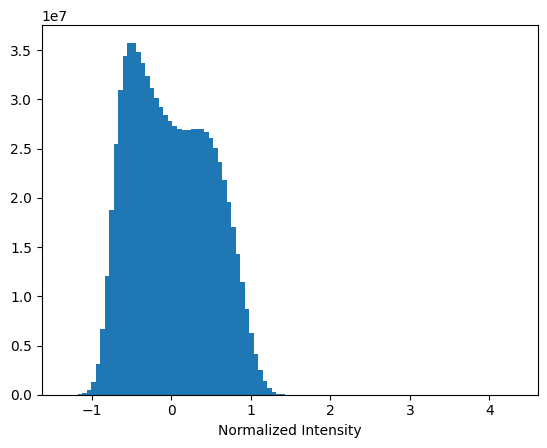

In [4]:
Intensities = np.array(Intensities)
Intensities_normalized = (Intensities - Intensities.mean())/(np.std(Intensities)*2)
print(Intensities_normalized.min(), Intensities_normalized.max(), Intensities_normalized.mean())
plt.hist(Intensities_normalized.flatten(), bins=100)
plt.xlabel('Normalized Intensity')
plt.show()


-1476041.1 1478152.6 1368.3193


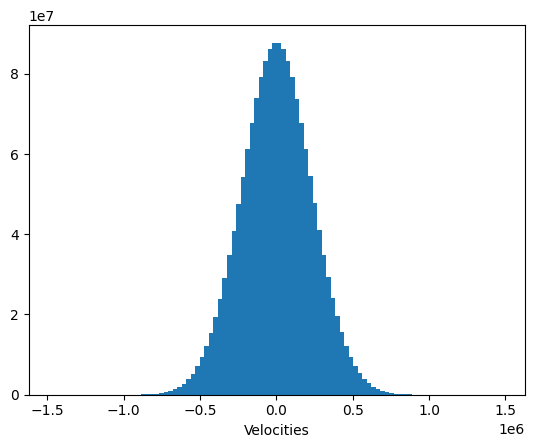

In [5]:
velocities = np.array(velocities)
print(velocities.min(), velocities.max(), velocities.mean())
plt.hist(velocities.flatten(), bins=100)
plt.xlabel('Velocities')
plt.show()

Intensity shape: (256, 256) range: 233172320.0 600930700.0
vx shape: (256, 256) range: -885625.1 929043.2
vy shape: (256, 256) range: -848144.75 857400.3
magnitude shape: (256, 256) range: 1187.494 1006168.94

 ################################################## 



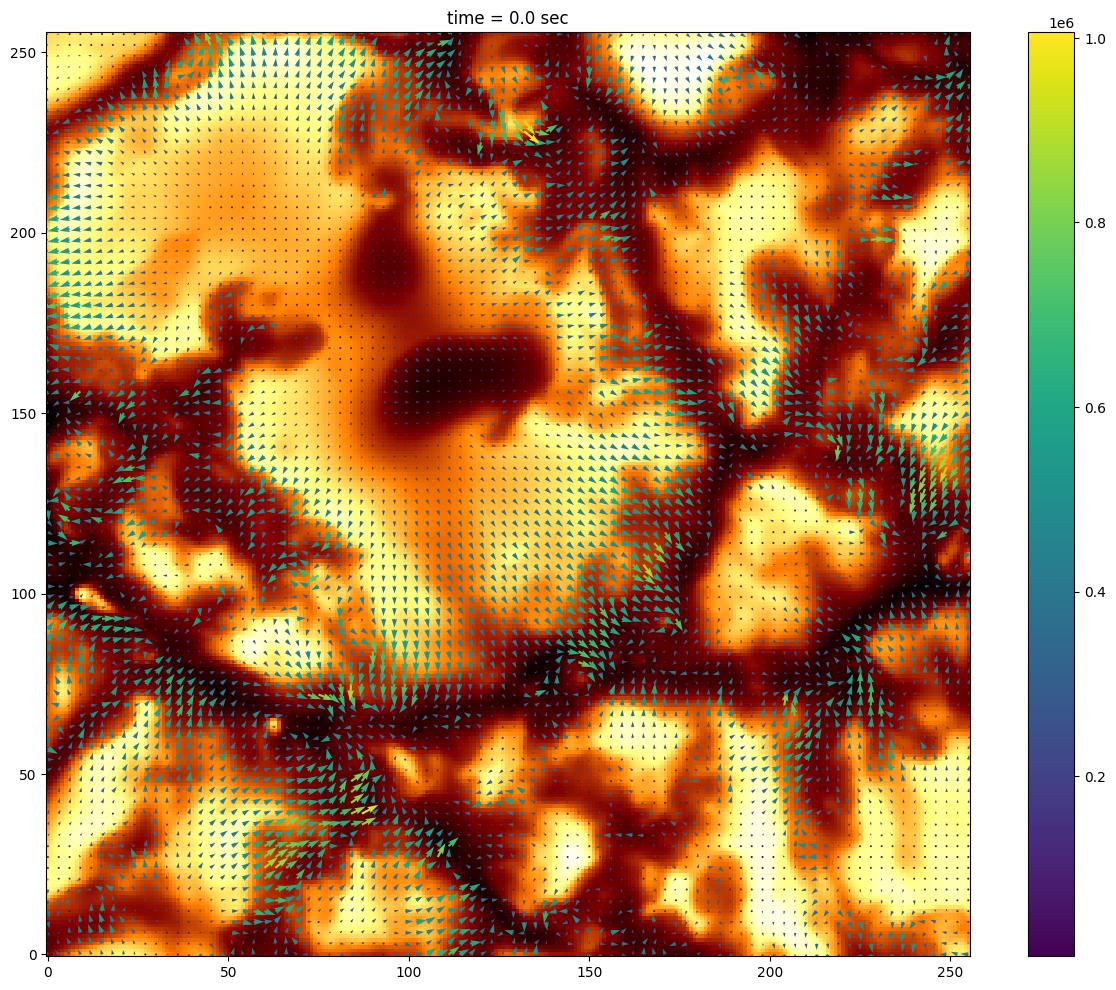

Intensity shape: (256, 256) range: 237884290.0 599867400.0
vx shape: (256, 256) range: -848703.06 911929.8
vy shape: (256, 256) range: -818615.4 953760.25
magnitude shape: (256, 256) range: 1220.6882 1047985.06

 ################################################## 



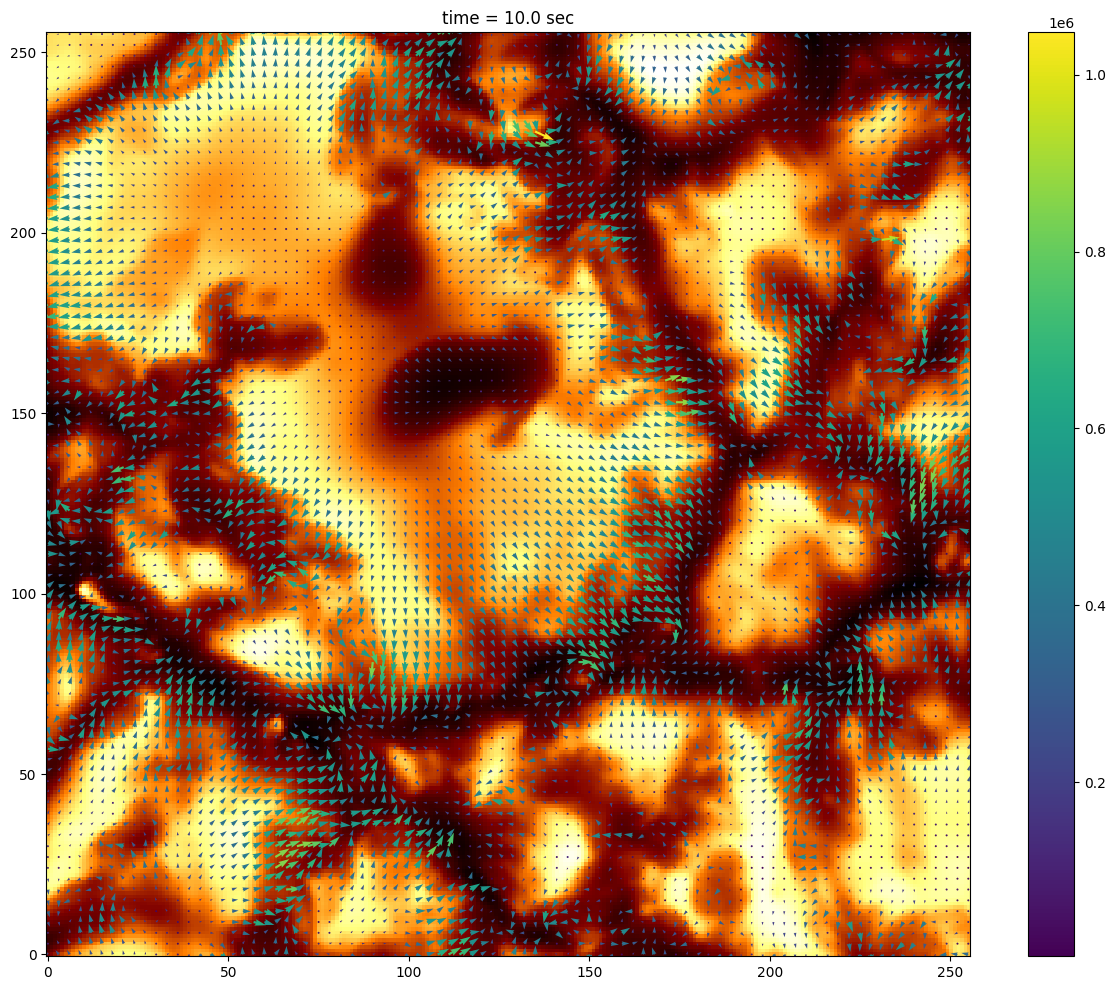

Intensity shape: (256, 256) range: 224741780.0 608233700.0
vx shape: (256, 256) range: -834006.7 792428.9
vy shape: (256, 256) range: -784319.6 921270.5
magnitude shape: (256, 256) range: 1598.1683 944647.94

 ################################################## 



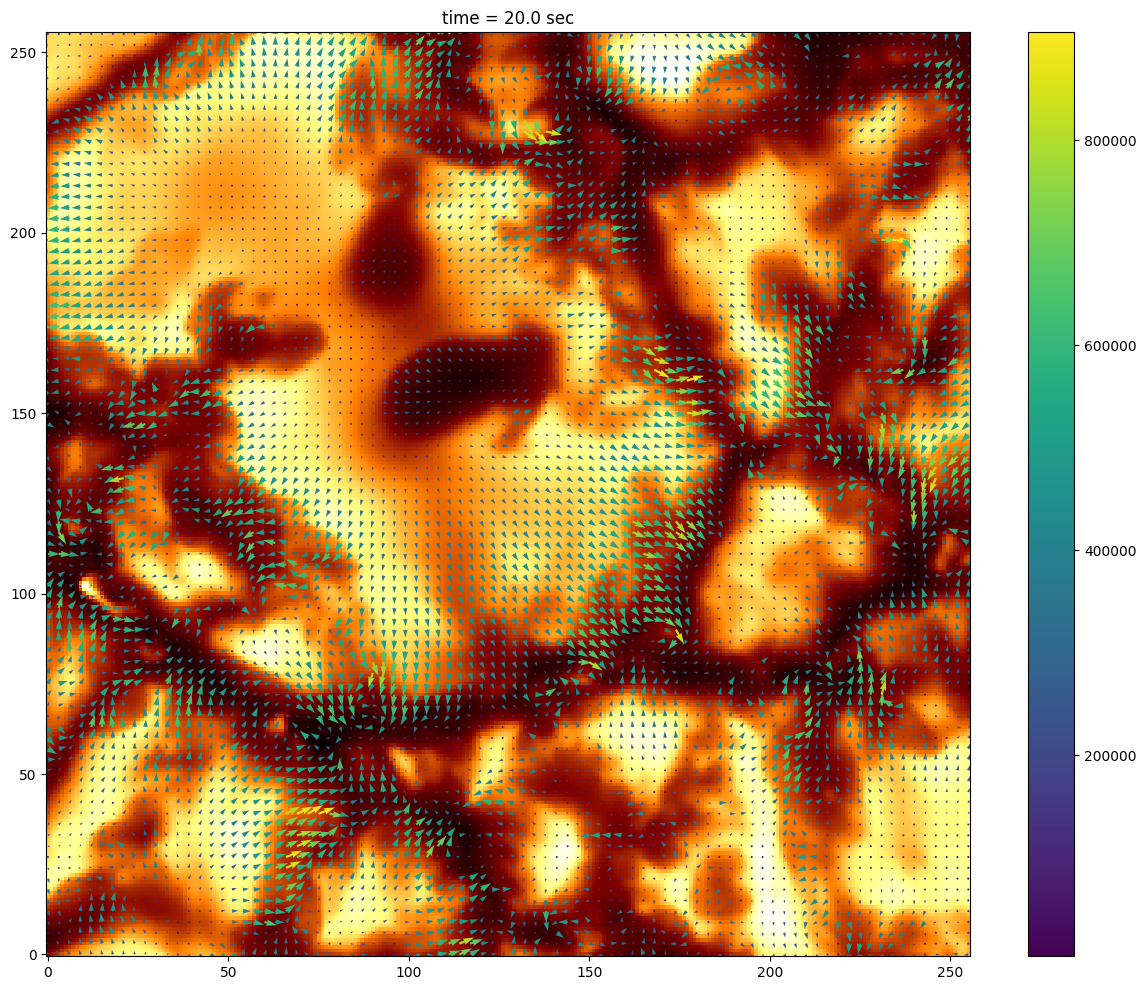

In [6]:
for i,time in enumerate(times[:3]):

    # Data
    Int = Intensities[i]
    vx, vy = velocities[i]
    region = slice(0,256), slice(0,256)  # Define region of interest

    magnitude = np.sqrt(vx[region]**2 + vy[region]**2)

    # Inspect data
    print("Intensity shape:", Int[region].shape, "range:", Int[region].min(), Int[region].max())
    print("vx shape:", vx[region].shape, "range:", vx[region].min(), vx[region].max())
    print("vy shape:", vy[region].shape, "range:", vy[region].min(), vy[region].max())
    print("magnitude shape:", magnitude.shape, "range:", magnitude.min(), magnitude.max())
    print("\n", "#"*50, "\n")

    vx, vy = vx[region], vy[region]

    stride = 3  # Reduce density
    x, y = np.meshgrid(np.arange(0, vx.shape[0], stride), np.arange(0, vx.shape[1], stride))

    # Plot
    plt.figure(figsize=(15,12))
    plt.imshow(Int[region], cmap='afmhot', origin='lower')
    plt.quiver(x, y, vy[::stride, ::stride], vx[::stride, ::stride], magnitude[::stride, ::stride], color='blue')
    plt.title(f"time = {time} sec")
    plt.colorbar()
    plt.savefig(f'output/plot_intensity_velocity_t_{time}.png', dpi=70)
    plt.show()


In [7]:
# make a generator that generate batches of random subsamples of 256, 256 images of 3 consecutive images,
# with random rotations (0, 90, 180, 270 degrees) and random flips
# and stores it, together with the corresponding labels (256, 256, 2) array of velocities from the middle image
# and the corresponding array of times (3,)

from dataset import data_generator

In [8]:
Intensities_subsample = Intensities[0:3]
velocities_subsample = velocities[0:3]
times_subsample = times[0:3]


In [9]:
# Create a generator instance with batch_size=1.
img_size = 32
gen = data_generator(Intensities_subsample, velocities_subsample, times_subsample, batch_size=1, img_size=img_size)

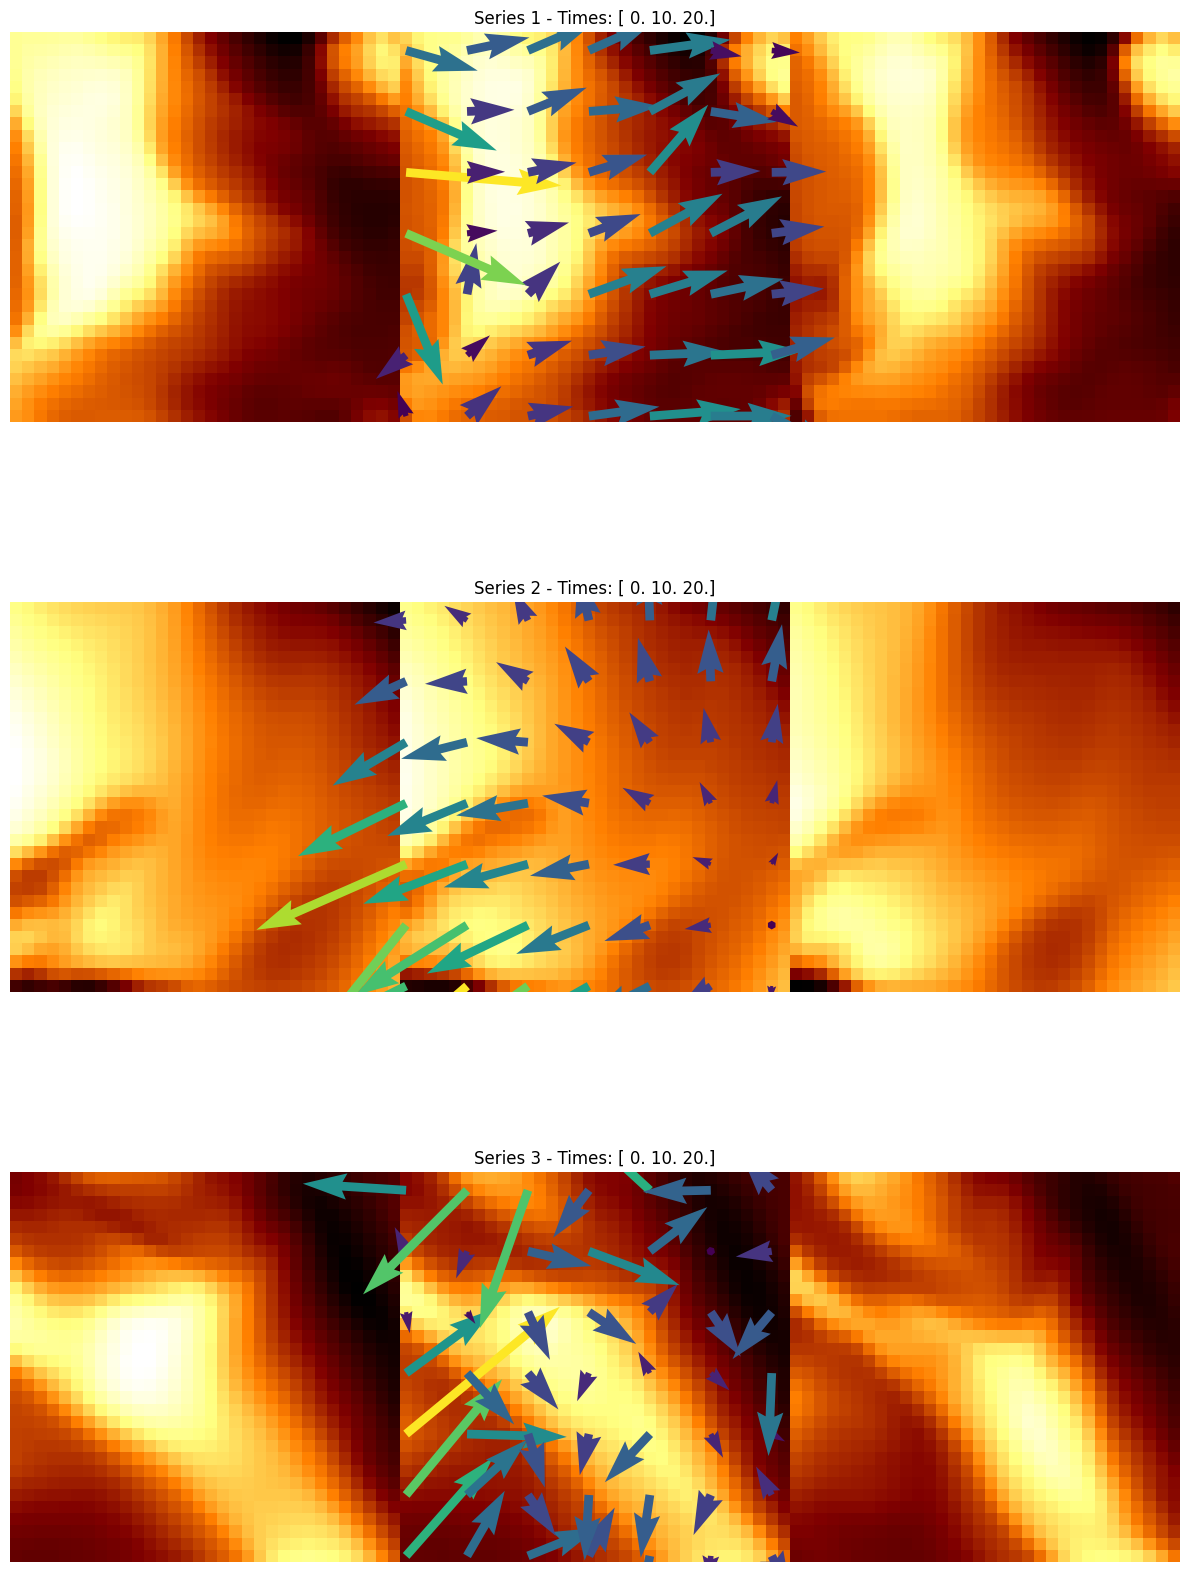

In [10]:


series_imgs = []       # Will store the concatenated intensity triplet images.
series_times = []      # Will store the corresponding triplet of times.
velocity_fields = []   # Will store the velocity patch (256,256,2) from the middle image.

# Generate 3 samples.
for i in range(3):
    X_batch, Y_batch, T_batch = next(gen)  # X_batch: (1, 256, 256, 3), Y_batch: (1, 256, 256, 2), T_batch: (1, 3)
    sample = X_batch[0]  # Extract the single sample from the batch.
    
    # Concatenate the 3 intensity images horizontally.
    concatenated = np.hstack([sample[..., j] for j in range(3)])
    series_imgs.append(concatenated)
    series_times.append(T_batch[0])
    
    # Save the velocity field from the middle image (shape: 256,256,2).
    velocity_fields.append(Y_batch[0])

# Now, plot the 3 concatenated series in a 3x1 subplot.
stride = 5  # Controls the density of quiver arrows.
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

for idx, ax in enumerate(axs):
    # Show the concatenated intensity triplet.
    ax.imshow(series_imgs[idx], cmap='afmhot', origin='lower')
    
    # The central patch (middle image) occupies columns img_size to 2*img_size.
    # We overlay the velocity vectors from the middle image here.
    # Create a grid over the img_sizeximg_size velocity patch.
    rows = np.arange(0, img_size, stride)
    cols = np.arange(0, img_size, stride)
    # Meshgrid where X corresponds to column index and Y to row index.
    Xgrid, Ygrid = np.meshgrid(cols, rows)
    # Offset the x-coordinates by 256 so that they match the middle image’s location.
    Xgrid_offset = Xgrid + img_size

    # Extract the velocity components.
    # Note: As in the original code, we swap the order in quiver (using vy as the horizontal component)
    # to match the simulation’s coordinate convention.
    vx_patch = velocity_fields[idx][:, :, 0]  # typically derived from tau_slice.vy
    vy_patch = velocity_fields[idx][:, :, 1]  # typically derived from tau_slice.vz
    # Sample the velocity field at the stride.
    vx_sample = vx_patch[::stride, ::stride]
    vy_sample = vy_patch[::stride, ::stride]

    magnitude = np.sqrt(vx_sample**2 + vy_sample**2)
    
    # Overlay the velocity vectors on the middle patch (using a scale to adjust arrow size).
    ax.quiver(Xgrid_offset, Ygrid, vy_sample, vx_sample, magnitude, color='blue')
    
    ax.set_title(f"Series {idx+1} - Times: {series_times[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [11]:
# Test the dataset and the dataloader
from dataset import MURAMVelocityDataset
from torch.utils.data import DataLoader

In [12]:
from torch.utils.data import DataLoader

# Initialize the dataset
dataset = MURAMVelocityDataset(Intensities_subsample, velocities_subsample, times_subsample, img_size=img_size)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=None)

/tmp/ipykernel_2901508/2298922254.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mag = np.sqrt(vx_sample_field**2 + vy_sample_field**2)


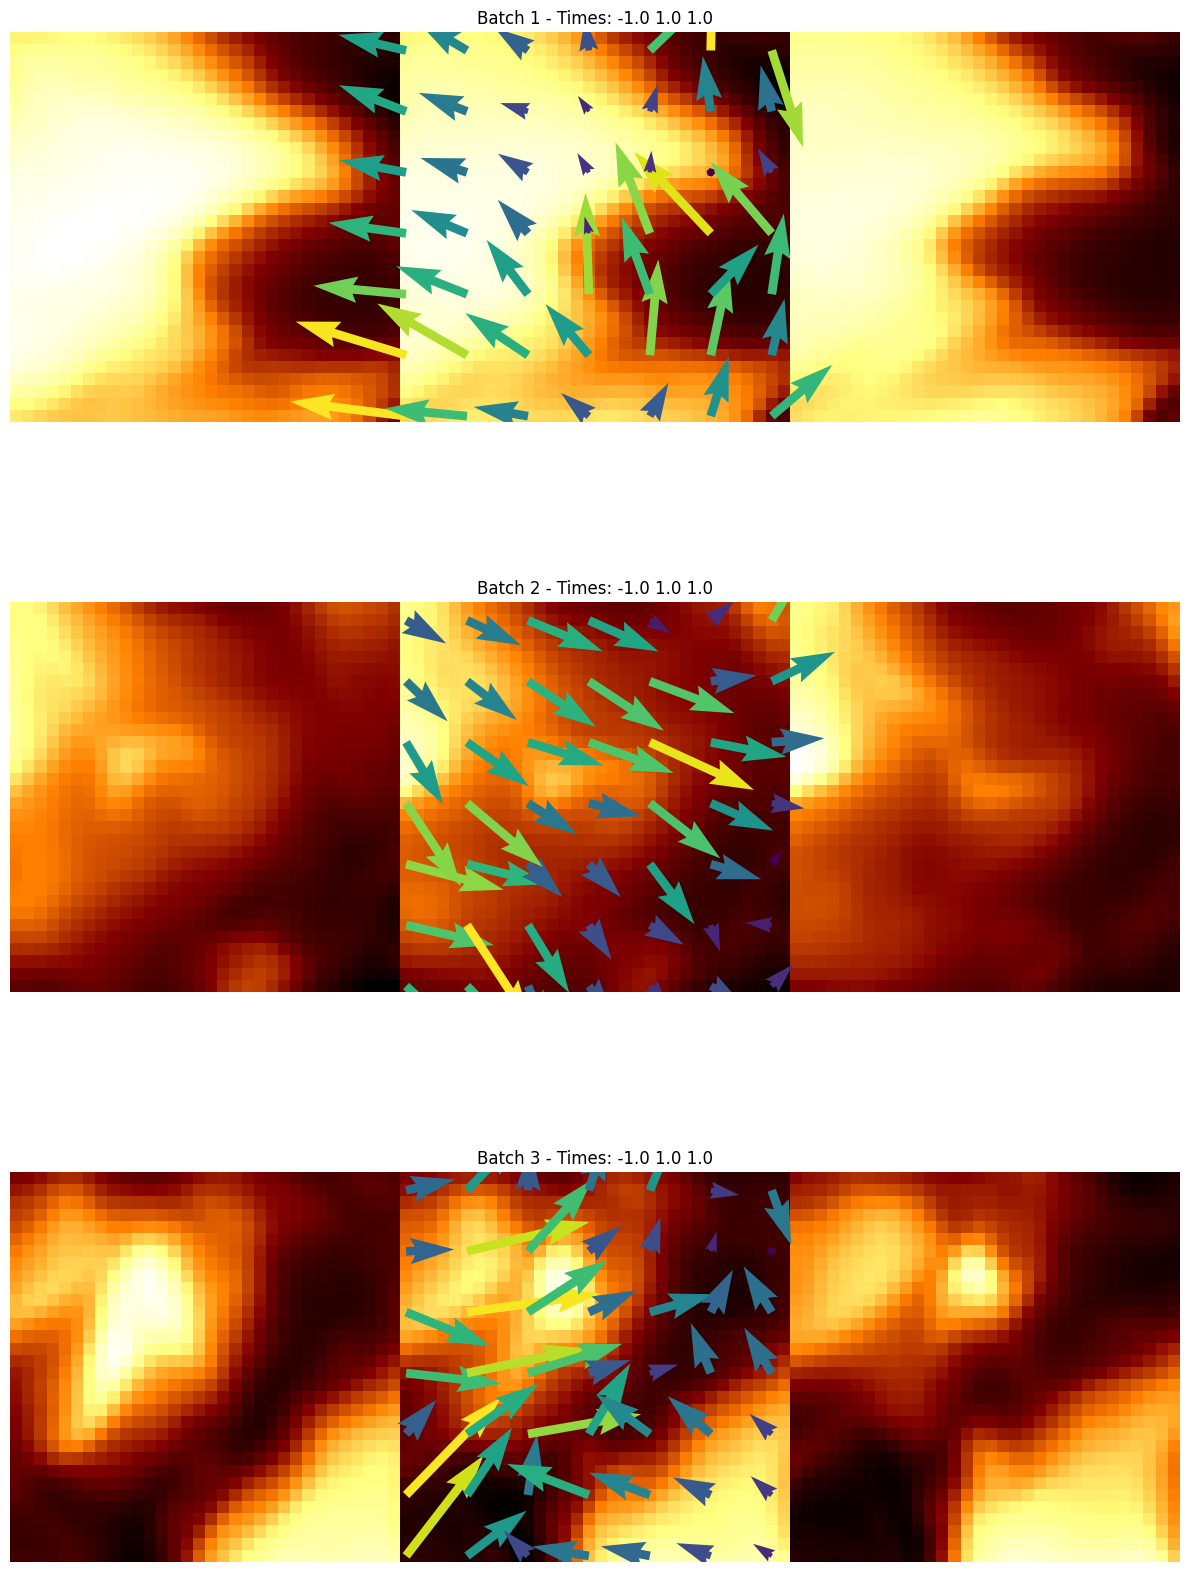

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Loop over the dataloader to get 3 samples/batches.
for i, sample in enumerate(dataloader):
    if i >= 3:
        break
    # Each sample is assumed to be a tuple (X, Y, T)
    # X: (H, W, 3) intensity triplet,
    # Y: (H, W, 2) velocity field,
    # T: (3,) times.
    X, Y, T = sample
    # Concatenate the 3 intensity images horizontally.
    concatenated = np.hstack([X[0, j, ...] for j in range(3)])
    
    # Create a grid for the velocity field (from the middle image).
    # Use the already defined stride.
    rows_idx = np.arange(0, Y.shape[-2], stride)
    cols_idx = np.arange(0, Y.shape[-1], stride)
    Xgrid, Ygrid = np.meshgrid(cols_idx, rows_idx)
    # Extract the velocity components; note the swaped order in quiver.
    vx_field = Y[0, 0, ...]
    vy_field = Y[0, 1, ...]
    vx_sample_field = vx_field[::stride, ::stride]
    vy_sample_field = vy_field[::stride, ::stride]
    # Since the middle image is the second one (assuming equal widths),
    # the intensity of the middle image is located in the center third.
    offset = concatenated.shape[1] // 3
    Xgrid_offset = Xgrid + offset

    ax = axs[i]
    ax.imshow(concatenated, cmap='afmhot', origin='lower')
    mag = np.sqrt(vx_sample_field**2 + vy_sample_field**2)
    ax.quiver(Xgrid_offset, Ygrid, vy_sample_field, vx_sample_field, mag, color='blue')
    ax.set_title(f"Batch {i+1} - Times: {T[0,0]} {T[0,1]} {T[0,2]}")
    ax.axis("off")

plt.tight_layout()
plt.show()